## Use of VFA methods
The goal of this notebook is to show if it is possible to use VFA methods in the Slimevolley gym environment.

In [1]:
from os.path import join
from slime import Slime
import pandas as pd
import numpy as np
import gym
import slimevolleygym
from algorithms import *

# Define our input folders and output files
DATADIR = join('..', 'data')

We get the csv file in which we saved the information of our centroids. In this case, we will use the 50K file.

In [2]:
centroids = pd.read_csv(join(DATADIR, 'c_50_mix.csv'))

We create the definition of the function for the feature vector, which is encapsulated in a Featurizer class.

In [3]:
slime_env = gym.make('SlimeVolley-v0')

In [4]:
featurizer = Featurizer(slime_env.observation_space, np.array(centroids))

### 50K centroids

In [5]:
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.5)
slime_q, slime_history, slime_history_average = sarsa_lambda(slime_env, q, 200, 1000, epsilon = 0.01) # alpha and epsilon values by default

: 

: 

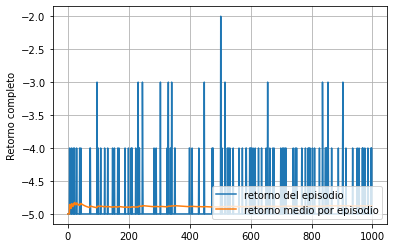

In [63]:
plot_history(slime_history, slime_history_average)

In [15]:
alpha = 0.001
beta = 0.005
v = ValueFunctionRB(featurizer)
pi = PolicyEstimator(featurizer, slime_env.action_space.n)
slime_pi, slime_history_b, slime_average_history_b = reinforce_baseline(slime_env, pi, v, 1500, 10000,
                                                                         alpha, beta, gamma = 0.98)

t = 50
t = 100
t = 150
t = 200
t = 250
t = 300
t = 350
t = 400
t = 450
t = 500
t = 550
t = 600
t = 650
t = 700
t = 750
t = 800
t = 850
t = 900
t = 950
t = 1000
t = 1050
t = 1100
t = 1150
t = 1200
t = 1250
episodio 2: alpha = 0.001, beta = 0.005, retorno medio = -0.259766122997451
t = 1300
t = 1350
t = 1400
t = 1450
t = 1500
t = 1550
t = 1600
t = 1650
t = 1700
t = 1750
t = 1800
t = 1850
t = 1900
t = 1950
t = 2000
t = 2050
t = 2100
t = 2150
t = 2200
t = 2250
episodio 4: alpha = 0.001, beta = 0.005, retorno medio = -0.2000035909863384
t = 2300
t = 2350
t = 2400
t = 2450
t = 2500
t = 2550
t = 2600
t = 2650
t = 2700
t = 2750
t = 2800
t = 2850
t = 2900
t = 2950
t = 3000
t = 3050
t = 3100
t = 3150
t = 3200
t = 3250
t = 3300
t = 3350
t = 3400
episodio 6: alpha = 0.001, beta = 0.005, retorno medio = -0.2151334590276119
t = 3450
t = 3500
t = 3550
t = 3600
t = 3650
t = 3700
t = 3750
t = 3800
t = 3850
t = 3900
t = 3950
t = 4000
t = 4050
t = 4100
t = 4150
t = 4200
t = 4250
t = 4300
t = 4350
t = 440

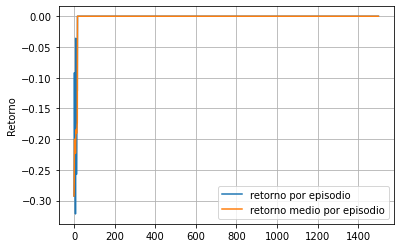

In [16]:
ax = plt.subplot(111)
plt.plot(slime_history_b, label="retorno por episodio")
plt.plot(slime_average_history_b, label="retorno medio por episodio")
plt.ylabel('Retorno', size=10)
ax.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
env = gym.make('SlimeVolley-v0')
S = env.reset()
G = 0     
while True:
    action = slime_pi[S]
    obs, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 

: 